In [ ]:
#| default_exp estimators

In [ ]:
#| export
#| include: false
#| echo: false
from __future__ import annotations # allows multiple typing of arguments in Python versions prior to 3.10

In [ ]:
#| include: false
#| echo: false
! [ -e /content ] && pip install -Uqq gingado nbdev # install or upgrade gingado on colab

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| include: false
from nbdev.showdoc import show_doc

In many instances, economists are interested in using machine learning models for specific purposes that go beyond their ability to predict variables to a good accuracy. For example:

- understanding the relationship between covariates and the outcome ("*coefficient-focused tasks*"), usually to demonstrate that a non-trivial effect of one variable on another exists.

- estimating a certain measure with certain desirable statistical and econometric properties ("*measure-focused tasks*"), where the object of interest is the predicted outcome of an adapted algorithm.

- identifying which covariates are related or not to a certain outcome ("*covariate-selection tasks*"), often to demonstrate the relevance of a certain theory.

- process non-traditional data (eg, text) for inclusion in a traditional econometrics regression ("*covariate-processing tasks*"), especially useful in settings where measurable quantitative data is complemented with this other type of data.

The `gingado.estimators` module contains machine learning algorithms adapted to enable the types of analyses described above. More estimators can be expected over time.

# Covariate-selection tasks

## Clustering

The clustering algorithms used below are not themselves adapted from the general use methods. Rather, the functions offer convenience functionalities to find and retain the other variables in the same cluster. 

These variables are usually entities (individuals, countries, stocks, etc) in a larger population.

The `gingado` clustering routines are designed to allow users standalone usage, or a seamless integration as part of a pipeline.

There are three levels of sophistication that users can choose from:

- using the off-the-shelf clustering routines provided by `gingado`, which were selected to be applied cross various use cases;

- selecting an existing clustering routine from the [`scikit-learn.cluster`](https://scikit-learn.org/stable/modules/clustering.html) module; or

- designing their own clustering algorithm.

In [ ]:
#| include: false
#| export

import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AffinityPropagation
from sklearn.utils.metaestimators import available_if

In [ ]:
#| include: false
#| export

class FindCluster(BaseEstimator):
    "Retain only the columns of `X` that are in the same cluster as `y`."

    def __init__(
        self,
        cluster_alg:[BaseEstimator,ClusterMixin]=AffinityPropagation(), # An instance of the clustering algorithm to use
        random_state:int|None=None, # The random seed to be used by the algorithm, if relevant
    ):
        self.cluster_alg = cluster_alg
        self.random_state = random_state
        if hasattr(self.cluster_alg, "random_state"):
            self.cluster_alg.set_params(random_state=self.random_state)


    def fit(
        self,
        X, # The population of entities, organised in columns
        y # The entity of interest
    ):
        "Fit `FindCluster`"
        temp_y_colname = "gingado_ycol"

        X[temp_y_colname] = y

        entities = X.columns
        y_mask = entities == temp_y_colname

        self.cluster_alg.fit(X.T)

        cluster = entities[self.cluster_alg.labels_ == self.cluster_alg.labels_[y_mask]]
        self.same_cluster_ = [e for e in cluster if e != temp_y_colname]
        return self

    def transform(
        self,
        X # The population of entities, organised in columns
    )->np.array: # Columns of `X` that are in the same cluster as `y`
        "Keep only the entities in `X` that belong to the same cluster as `y`"
        return X[self.same_cluster_]

    def fit_transform(
        self,
        X, # The population of entities, organised in columns
        y # The entity of interest
    )->np.array: # Columns of `X` that are in the same cluster as `y`
        "Fit a `FindCluster` object and keep only the entities in `X` that belong to the same cluster as `y`"
        self.fit(X, y)
        return self.transform(X)

In [ ]:
show_doc(FindCluster)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L20){target="_blank" style="float:right; font-size:smaller"}

### FindCluster

>      FindCluster (cluster_alg:[<class'sklearn.base.BaseEstimator'>,<class'skle
>                   arn.base.ClusterMixin'>]=AffinityPropagation(),
>                   random_state:int|None=None)

Retain only the columns of `X` that are in the same cluster as `y`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| cluster_alg | [BaseEstimator, ClusterMixin] | AffinityPropagation() | An instance of the clustering algorithm to use |
| random_state | int \| None | None | The random seed to be used by the algorithm, if relevant |

In [ ]:
show_doc(FindCluster.fit, name="fit", title_level=4)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L34){target="_blank" style="float:right; font-size:smaller"}

#### fit

>      fit (X, y)

Fit `FindCluster`

|    | **Details** |
| -- | ----------- |
| X | The population of entities, organised in columns |
| y | The entity of interest |

In [ ]:
show_doc(FindCluster.transform, name="transform", title_level=4)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L53){target="_blank" style="float:right; font-size:smaller"}

#### transform

>      transform (X)

Keep only the entities in `X` that belong to the same cluster as `y`

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| X |  | The population of entities, organised in columns |
| **Returns** | **np.array** | **Columns of `X` that are in the same cluster as `y`** |

In [ ]:
show_doc(FindCluster.fit_transform, name="fit_transform", title_level=4)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L60){target="_blank" style="float:right; font-size:smaller"}

#### fit_transform

>      fit_transform (X, y)

Fit a `FindCluster` object and keep only the entities in `X` that belong to the same cluster as `y`

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| X |  | The population of entities, organised in columns |
| y |  | The entity of interest |
| **Returns** | **np.array** | **Columns of `X` that are in the same cluster as `y`** |

The @BARRO19941 dataset is used to illustrate the use of `FindCluster`. It is a country-level dataset. Let's use it to answer the following question: for some specific country, what other countries are the closest to it considering the data available?

First, we import the data:

In [ ]:
from gingado.datasets import load_BarroLee_1994

The data is organized by rows: each row is a different country, and the variables are organised in columns. 

The dataset is originally organised for a regression of GDP growth (here denoted `y`) on the covariates (`X`). This is not what we want to do in this case. So instead of keeping GDP as a separate variable, the next step is to include it in the `X` DataFrame.

In [ ]:
X, y = load_BarroLee_1994()
X['gdp'] = y
X.head()

,Unnamed: 0,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,...,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1,gdp
0,0,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,...,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727,-0.024336
1,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,...,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750,0.100473
2,2,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,...,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040,0.067051
3,3,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,...,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195,0.064089
4,4,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,...,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283,0.027930


Now we remove the first column (an identifier) and transpose the DataFrame, so that countries are organized in columns.

Each country is identified by a number: 0, 1, ...

In [ ]:
X = X.iloc[:, 1:]
countries = X.T
countries.columns = ['country_' + str(c) for c in countries.columns]
countries.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,...,country_80,country_81,country_82,country_83,country_84,country_85,country_86,country_87,country_88,country_89
gdpsh465,6.591674,6.829794,8.895082,7.565275,7.162397,7.218910,7.853605,7.703910,9.063463,8.151910,...,9.030974,8.995537,8.234830,8.332549,8.645586,8.991064,8.025189,9.030137,8.865312,8.912339
bmp1l,0.283700,0.614100,0.000000,0.199700,0.174000,0.000000,0.000000,0.277600,0.000000,0.148400,...,0.000000,0.000000,0.036300,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000
freeop,0.153491,0.313509,0.204244,0.248714,0.299252,0.258865,0.182525,0.215275,0.109614,0.110885,...,0.293138,0.304720,0.288405,0.345485,0.288440,0.371898,0.296437,0.265778,0.282939,0.150366
freetar,0.043888,0.061827,0.009186,0.036270,0.037367,0.020880,0.014385,0.029713,0.002171,0.028579,...,0.005517,0.011658,0.011589,0.006503,0.005995,0.014586,0.013615,0.008629,0.005048,0.024377
h65,0.007000,0.019000,0.260000,0.061000,0.017000,0.023000,0.039000,0.024000,0.402000,0.145000,...,0.245000,0.246000,0.183000,0.188000,0.256000,0.255000,0.108000,0.288000,0.188000,0.257000


Suppose we are interested in country No 13. What other countries are similar to it?

First, country No 13 needs to be carved out of the DataFrame with the other countries.

Second, we can now pass the larger DataFrame and country 13's data separately to an instance of `FindCluster`.

In [ ]:
country_of_interest = countries.pop('country_13')


In [ ]:
similar = FindCluster(AffinityPropagation(convergence_iter=5000))
similar

FindCluster(cluster_alg=AffinityPropagation(convergence_iter=5000))

In [ ]:
same_cluster = similar.fit_transform(X=countries, y=country_of_interest)

assert same_cluster.equals(similar.fit(X=countries, y=country_of_interest).transform(X=countries))

same_cluster

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


,country_2,country_9,country_41,country_48,country_49,country_52,country_60,country_64,country_66
gdpsh465,8.895082,8.151910,7.360740,6.469250,5.762051,9.224933,8.346168,7.655864,7.830028
bmp1l,0.000000,0.148400,0.418100,0.538800,0.600500,0.000000,0.319900,0.134500,0.488000
freeop,0.204244,0.110885,0.218471,0.153491,0.151848,0.204244,0.110885,0.164598,0.136287
freetar,0.009186,0.028579,0.027087,0.043888,0.024100,0.009186,0.028579,0.044446,0.046730
h65,0.260000,0.145000,0.032000,0.015000,0.002000,0.393000,0.272000,0.080000,0.146000
...,...,...,...,...,...,...,...,...,...
ex1,0.174100,0.052400,0.190500,0.069200,0.148400,0.255800,0.062500,0.052500,0.076400
im1,0.175000,0.052300,0.225700,0.074800,0.186400,0.241200,0.057800,0.057200,0.086600
xr65,1.082000,2.119000,3.949000,0.348000,7.367000,1.017000,36.603000,30.929000,40.500000
tot1,-0.010040,0.007584,0.205768,0.035226,0.007548,0.018636,0.014286,-0.004592,-0.007018


The default clustering algorithm used by `FindCluster` is affinity propagation [@frey2007clustering]. It is the algorithm of choice because of it combines several desireable characteristics, in particular:
- the number of clusters is data-driven instad of set by the user,
- the number of entities in each cluster is also chosen by the model, 
- all entities are part of a cluster, and
- each cluster might have a different number of entities.

However, we may want to try different clustering algorithms. Let's compare the result above with the same analyses using DBSCAN [@ester1996density].

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
similar_dbscan = FindCluster(cluster_alg=DBSCAN())
similar_dbscan

FindCluster(cluster_alg=DBSCAN())

In [ ]:
same_cluster_dbscan = similar_dbscan.fit_transform(X=countries, y=country_of_interest)

assert same_cluster_dbscan.equals(similar_dbscan.fit(X=countries, y=country_of_interest).transform(X=countries))

same_cluster_dbscan

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,...,country_80,country_81,country_82,country_83,country_84,country_85,country_86,country_87,country_88,country_89
gdpsh465,6.591674,6.829794,8.895082,7.565275,7.162397,7.218910,7.853605,7.703910,9.063463,8.151910,...,9.030974,8.995537,8.234830,8.332549,8.645586,8.991064,8.025189,9.030137,8.865312,8.912339
bmp1l,0.283700,0.614100,0.000000,0.199700,0.174000,0.000000,0.000000,0.277600,0.000000,0.148400,...,0.000000,0.000000,0.036300,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000
freeop,0.153491,0.313509,0.204244,0.248714,0.299252,0.258865,0.182525,0.215275,0.109614,0.110885,...,0.293138,0.304720,0.288405,0.345485,0.288440,0.371898,0.296437,0.265778,0.282939,0.150366
freetar,0.043888,0.061827,0.009186,0.036270,0.037367,0.020880,0.014385,0.029713,0.002171,0.028579,...,0.005517,0.011658,0.011589,0.006503,0.005995,0.014586,0.013615,0.008629,0.005048,0.024377
h65,0.007000,0.019000,0.260000,0.061000,0.017000,0.023000,0.039000,0.024000,0.402000,0.145000,...,0.245000,0.246000,0.183000,0.188000,0.256000,0.255000,0.108000,0.288000,0.188000,0.257000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ex1,0.072900,0.094000,0.174100,0.126500,0.121100,0.063400,0.034200,0.086400,0.059400,0.052400,...,0.166200,0.259700,0.104400,0.286600,0.129600,0.440700,0.166900,0.323800,0.184500,0.187600
im1,0.066700,0.143800,0.175000,0.149600,0.130800,0.076200,0.042800,0.093100,0.046000,0.052300,...,0.161700,0.228800,0.179600,0.350000,0.145800,0.425700,0.220100,0.313400,0.194000,0.200700
xr65,0.348000,0.525000,1.082000,6.625000,2.500000,1.000000,12.499000,7.000000,1.000000,2.119000,...,4.286000,2.460000,32.051000,0.452000,652.850000,2.529000,25.553000,4.152000,0.452000,0.886000
tot1,-0.014727,0.005750,-0.010040,-0.002195,0.003283,-0.001747,0.009092,0.011630,0.008169,0.007584,...,-0.006642,-0.003241,-0.034352,-0.001660,-0.046278,-0.011883,-0.039080,0.005175,-0.029551,-0.036482


As illustrated above, the results can be quite different. In this case, affinity propagation converged to more tightly defined clusters, while DBSCAN selected a cluster that contains almost all other countries (therefore, not useful in this particular case).

`FindCluster` can also be used as part of a [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline). In this case, only the entities in the same cluster as the entity of interest will continue on to the next steps of the estimation.

# Measure-focused tasks

## Machine controls

> The machine learning version of synthetic controls methodology (@abadie2021using)


In [ ]:
#| include: false
#| export

import pandas as pd

from gingado.benchmark import ggdBenchmark, RegressionBenchmark
from gingado.model_documentation import ggdModelDocumentation, ModelCard
from sklearn.base import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

In [ ]:
#| include: false
#| export

class MachineControl(BaseEstimator):
    "Estimate synthetic controls with machine learning methods"

    def __init__(
        self,
        # An instance of the clustering algorithm to use, or None to retain all entities
        cluster_alg:[BaseEstimator,ClusterMixin]|None=AffinityPropagation(),
        # Method to weight the control entities
        estimator:BaseEstimator=RegressionBenchmark(), 
        # Algorithm for manifold learning
        manifold:BaseEstimator=TSNE(),
        # Include placebo estimations during prediction?
        with_placebo:bool=True,
        # The random seed to be used by the algorithm, if relevant
        random_state:int|None=None,
        # gingado Documenter template to facilitate model documentation
        auto_document:ggdModelDocumentation=ModelCard
    ):
        self.cluster_alg = cluster_alg
        self.estimator = estimator
        self.manifold = manifold
        self.with_placebo = with_placebo
        self.random_state = random_state
        self.auto_document = auto_document

        if hasattr(self.cluster_alg, "random_state"):
            self.cluster_alg.set_params(random_state=self.random_state)
        if hasattr(self.estimator, "random_state"):
            self.estimator.set_params(random_state=self.random_state)
        if hasattr(self.manifold, "random_state"):
            self.manifold.set_params(random_state=self.random_state)    

        self.pipeline = Pipeline([
            ('donor_pool', self.cluster_alg),
            ('estimator', self.estimator)
        ])

    def _placebo(self):
        pass

    def _select_controls(
        self,
        X:pd.DataFrame, # A pandas DataFrame with pre-intervention data of shape (n_samples, n_control_entites)
        y:pd.DataFrame|pd.Series # A pandas DataFrame or Series with pre-intervention data of shape (n_samples,)
    ): # 
        "Identifies which columns of `X` should be used as controls"
        if self.cluster_alg is None:
            self.donor_pool_ = X.columns
        else:
            Xy = pd.concat([X, y], axis=1)
            self.cluster_alg.fit(Xy.T)
            idx_y = Xy.columns == y.name
            self.donor_pool_ = [
                c for c in Xy.columns[self.cluster_alg.labels_ == self.cluster_alg.labels_[idx_y]]
                if c != y.name
            ]

    def get_controls(self):
        "Get the list of control entities"
        if hasattr(self, "donor_pool_"):
            return self.donor_pool_
        else:
            "Controls not selected yet"

    def _compare_controls(
        self,
        X:np.ndarray, # Array-like pre-intervention data of shape (n_samples, n_control_entites)
        y:np.ndarray # Array-like pre-intervention data of shape (n_samples,)
    )->[np.ndarray, np.ndarray]: # 2-d representation of the treated entity, controls, and the synthetic control
        "Calculates the 2-d manifold learning distribution and locates the distance between target and control in this distribution"
        df_manifold_learning = pd.concat([
            pd.DataFrame(X), 
            pd.DataFrame(self.machine_controls_),
            pd.DataFrame(y) # if actual data is last, it is easier to do the distance learning
        ], axis=1)
        self.manifold_embed_ = self.manifold.fit_transform(X=df_manifold_learning.T)
        self.distances_ = squareform(pdist(self.manifold_embed_))[-1,:-1] # last position in the resulting array is the dist between actual and synth control
        self.control_quality_test_ = np.percentile(self.distances_, self.distances_[-1])

    def fit(
        self,
        X:pd.DataFrame, # A pandas DataFrame with pre-intervention data of shape (n_samples, n_control_entites)
        y:pd.DataFrame|pd.Series # A pandas DataFrame or Series with pre-intervention data of shape (n_samples,)
    ):
        "Fit the `MachineControl` model"
        
        self._select_controls(X=X, y=y)
        
        X_donor, y = self._validate_data(X[self.donor_pool_], y)
        
        self.estimator.fit(X=X_donor, y=y)
        
        self.machine_controls_ = self.estimator.predict(X=X_donor)

        # for the comparison part, note we use everyone, not just the selected control entities
        # this allows us to use a more robust test of whether there are many out-of-cluster entity
        # that would by itself be closer to the target entity.
        self._compare_controls(X=X.values, y=y)

        if self.with_placebo:
            self._placebo()

        return self

    def predict(
        self,
        X:pd.DataFrame # A pandas DataFrame with complete time series (pre- and post-intervention) of shape (n_samples, n_control_entites)
    ):
        "Calculate the model predictions before and after the intervention"
        check_is_fitted(self.estimator)
        pred = self.estimator.predict(X=X)

        if self.with_placebo:
            self._placebo()

        return pred


In [ ]:
show_doc(MachineControl)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L77){target="_blank" style="float:right; font-size:smaller"}

### MachineControl



Estimate synthetic controls with machine learning methods

In [ ]:
show_doc(MachineControl.fit, name="fit", title_level=4)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L106){target="_blank" style="float:right; font-size:smaller"}

#### fit

>      fit (X:numpy.ndarray, y:numpy.ndarray)

Fit the `MachineControl` model

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| X | np.ndarray | Array-like pre-intervention data of shape (n_samples, n_control_entites) |
| y | np.ndarray | Array-like pre-intervention data of shape (n_samples,) |

In [ ]:
show_doc(MachineControl.predict, name="predict", title_level=4)

---

[source](https://github.com/dkgaraujo/gingado/blob/main/gingado/estimators.py#L77){target="_blank" style="float:right; font-size:smaller"}

#### predict



Estimate synthetic controls with machine learning methods

In [ ]:
show_doc(MachineControl.get_controls, name="get_controls", title_level=4)

---

#### get_controls

>      get_controls ()

Get the list of control entities

The use of `MachineControl` estimator is illustrated with an admittedly simplistic estimation of the impact of softening labour regulation on output per worker (in constant 2017 international US dollars PPP).

More specifically, the example below focuses on Brazil's 2017 labour reforms (Law No 13,467/2017). The reform substantially deregulated labour markets, with the purpose of increasing productivity and thereby unlocking growth. Some of its main points are:
- prominence of collective bargaining between firms and employees over statutory "blanket" provisions
- lower costs for employers of employment termination without just cause
- discouraging of labour litigation by employees, previously diagnosed as being excessive and contributing to clogging the judicial system 

The reform was enacted in July 2017 and went into effect in November of the same year.

`MachineControl` does the following:
1. automatically select a group of countries from a global list to form a smaller set of control countries
2. estimate a GDP value for "synthetic Brazil" using pre-enactment data on the outcome of interest
3. check the statistical quality of the synthetic control
4. calculates the difference between post-reforms actual Brazilian GDP growth to synthetic Brazil's to measure the effect of the labour reform.

> Note: There are many other variables that would be interesting for this study as well, such as various labour market indicators.

In [ ]:
from gingado.utils import list_all_dataflows, load_SDMX_data

In [ ]:
dflows = list_all_dataflows(return_pandas=True)

2023-09-13 23:05:09,699 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-13 23:05:14,247 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-13 23:05:34,763 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-13 23:05:35,710 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-13 23:05:38,549 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-13 23:05:39,476 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>


In [ ]:
dflows[dflows.str.contains('GDP', case=False)]

BIS    WS_CREDIT_GAP                                    BIS credit-to-GDP gaps
ILO    DF_GDP_205U_NOC_NB    Output per worker (GDP constant 2015 US $) -- ...
       DF_GDP_211P_NOC_NB    Output per worker (GDP constant 2017 internati...
       DF_GDP_PHRW_NOC_NB    Output per hour worked (GDP constant 2017 inte...
       DF_LAP_2GDP_NOC_RT    Labour income share as a percent of GDP -- ILO...
       DF_SDG_1041_NOC_RT    SDG indicator 10.4.1 - Labour income share as ...
       DF_SDG_A821_NOC_RT    SDG indicator 8.2.1 - Annual growth rate of ou...
       DF_SDG_B821_NOC_RT    SDG indicator 8.2.1 - Annual growth rate of ou...
IMF    NAG_NSTD                           National Accounts - GDP_Non-Standard
INSEE  CNA-2010-PIB          Gross domestic product (GDP) and its component...
       CNA-2014-PIB            Gross domestic product (GDP) and its components
ISTAT  163_156               Gross domestic product, expenditure components...
       285_245               Contributions to GDP gr

In [ ]:
outcome_var = load_SDMX_data(
    sources={'ILO': 'DF_GDP_211P_NOC_NB'}, 
    keys={'FREQ': 'A'}, 
    params={'startPeriod': 2000, 'endPeriod': 2022}
)

2023-09-14 00:27:59,500 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>


Querying data from ILO's dataflow 'DF_GDP_211P_NOC_NB' - Output per worker (GDP constant 2017 international $ at PPP) -- ILO modelled estimates, Nov. 2022...


2023-09-14 00:28:00,913 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


This dataflow provides one series for each country, as seen below:.

In [ ]:
col_fields = pd.DataFrame([c.split("__") for c in outcome_var.columns])
for col in col_fields.columns:
    print("No of unique values for column No", col, ": ", col_fields[col].nunique())
print("\nFirst five rows:")
print(col_fields.head())

No of unique values for column No 0 :  1
No of unique values for column No 1 :  271
No of unique values for column No 2 :  1
No of unique values for column No 3 :  1

First five rows:
     0                       1  2            3
0  ILO  DF_GDP_211P_NOC_NB_AFG  A  GDP_211P_NB
1  ILO  DF_GDP_211P_NOC_NB_AGO  A  GDP_211P_NB
2  ILO  DF_GDP_211P_NOC_NB_ALB  A  GDP_211P_NB
3  ILO  DF_GDP_211P_NOC_NB_ARE  A  GDP_211P_NB
4  ILO  DF_GDP_211P_NOC_NB_ARG  A  GDP_211P_NB


Because 271 is much higher than the number of countries that usually report international statistics (close to 200), it is likely some 70 columns or more correspond to aggregations, typically used in statistics for convenience (eg, one code that encompasses all countries in the European Union, etc). We need to take them out, in case Brazil is a constituent of any of those aggregations.

One common way of spotting these aggregations in international statistics is by country codes that begin with "X".

In [ ]:
len([c for c in outcome_var.columns if "DF_GDP_211P_NOC_NB_X" in c])

82

Also, we will take out other countries that have undergone labour reforms more or less around the same area. I am aware of Argentina, Costa Rica, Paraguay, and Uruguay [@serra2022reforma], noting that these are only individually noted because, by virtue of being in the same geographical areas as Brazil, they were studied as potentially having the largest effect.

In [ ]:
col_filter = [
    c for c in outcome_var.columns
    if "DF_GDP_211P_NOC_NB_X" not in c
    and "DF_GDP_211P_NOC_NB_ARG" not in c
    and "DF_GDP_211P_NOC_NB_PAR" not in c
]

X = outcome_var[col_filter]
X = X.dropna(axis=1)

# cleaning out the name to remove the constant portions across all countries
X.columns = [c.replace("ILO__DF_GDP_211P_NOC_NB_", "").replace("__A__GDP_211P_NB", "") for c in X.columns]

col_BRA = [c for c in X.columns if c == "BRA"]
y = X.pop(col_BRA[0])

assert X.shape[0] == y.shape[0]

This is what the series of annual output per worker in Brazil looks like. A vertical line marking November 2017, when the labour reforms entered into force.

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Labour productivity in Brazil')

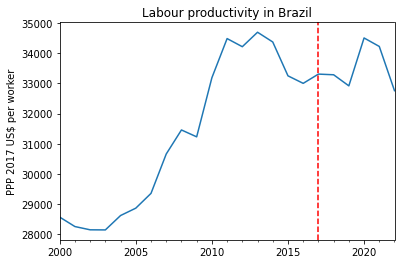

In [ ]:
ax = y.plot(legend=False)
ax.axvline(x='2017-11-11', color='r', linestyle='--')
plt.ylabel('PPP 2017 US$ per worker')
plt.xlabel('')
plt.title("Labour productivity in Brazil")

Before creating the `MachineControl` object, a final comment on the intervention date.

Since the reforms were enacted and entered into force in the same year of 2017, we can be conservative and consider:
- pre-intervention data up to end-2016
- post-intervention data from 2018 onwards

In [ ]:
X_pre, y_pre = X[:'2016-12-31'], y[:'2016-12-31']
X_post, y_post = X['2018-01-01':], y['2018-01-01':]

In [ ]:
X_pre.shape, y_pre.shape

((17, 183), (17,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
synth_BR = MachineControl(
    cluster_alg=AffinityPropagation(max_iter=10_000),
    estimator=RandomForestRegressor(),
    manifold=TSNE(perplexity=5)
)
synth_BR._select_controls(X_pre, y_pre)

<AxesSubplot:xlabel='TIME_PERIOD'>

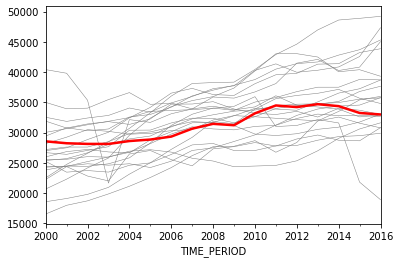

In [ ]:
ax = X_pre[synth_BR.donor_pool_].plot(legend=False, color="grey", linewidth=0.5)
y_pre.plot(ax=ax, color="red", linewidth=2.5)

In [ ]:
synth_BR.fit(X_pre, y_pre)

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


MachineControl(cluster_alg=AffinityPropagation(max_iter=10000),
               estimator=RandomForestRegressor(), manifold=TSNE(perplexity=5))

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


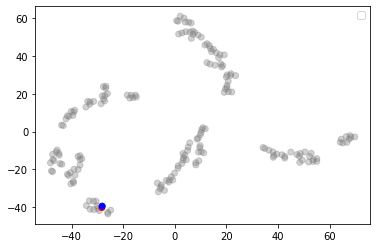

In [ ]:
colors = [(0.5, 0.5, 0.5, 0.35)] * X.shape[1] + ['red', 'blue']

fig, ax = plt.subplots()
ax.scatter(
    synth_BR.manifold_embed_[:, 0], synth_BR.manifold_embed_[:, 1],
    color=colors,
    )
ax.legend()
plt.show()

In [ ]:
synth_BR.control_quality_test_ / 100

(0.020255679830091376, 0.7443352406500573)

As can be seen in the graph above, the actual Brazil (blue) and the machine controls (red) are almost juxtaposed.

To confirm objectively that the control is good, the Euclidean distance between the embeddings for the control and the actual outcome are one of the lowest, more specifically at the 2% percentile. 

Together, both point to a strong signal that the control managed to replicate the pre-intervention outcome.

> TODO: placebo test, aggregated vs cumualative effects

# References